In [1]:
import pandas as pd
import numpy as np

import scipy.sparse
import sklearn.feature_extraction

import matplotlib.pylab as plt
%matplotlib inline

from tqdm import tqdm
import platform

pd.set_option("display.max_rows", 10)
pd.set_option('display.max_columns', 1100)

import os

%pylab inline
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/levabd/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### В матрице Main table всего 3 столбца, которые глобально характеризуют хэдэр

In [2]:
from logParser import ParseLogsFromFolder

main_data, values_data, order_data = ParseLogsFromFolder('Logs/', 1, 10, only_order=False)

main = pd.DataFrame(main_data)
del(main_data)
print('Shape: ' + str(main.shape))
main.head()

  7%|▋         | 9/127 [00:06<01:22,  1.43it/s]


Shape: (289269, 3)


,User_Agent,id,ip
0,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,1485900038,95.181.252.91
1,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,1485900047,40.77.167.74
2,Mozilla/5.0 (Linux; Android 4.4.2; Zera S Buil...,1485900079,31.148.3.19
3,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:51.0) G...,1485900103,188.162.183.66
4,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,1485900105,37.144.52.103


In [3]:
print('Хэдэры первых 100 юзер-агентов составляют: {:.2%}'.format(
    main.User_Agent.value_counts()[:100].sum() / main.shape[0]))

print('Сохраним индексы хэдэров из топ-100')
main_top_100 = main[main.User_Agent.isin(main.User_Agent.value_counts()[:100].index)]
#del(main)

top_ua = main.User_Agent.value_counts()[:100].index.tolist()

Хэдэры первых 100 юзер-агентов составляют: 62.87%
Сохраним индексы хэдэров из топ-100


In [4]:
print('В order_data содержится информация о взаимном расположении ключей.')
print('Переведем ее к типу csr с помощью DictVectorizer')
orders_vectorizer = sklearn.feature_extraction.DictVectorizer(sparse=True, dtype=float)
sparse_orders = orders_vectorizer.fit_transform(order_data).astype(np.int8)
del(order_data)

В order_data содержится информация о взаимном расположении ключей.
Переведем ее к типу csr с помощью DictVectorizer


Можно было бы сразу создать нужную нам спарс матрицу с признаками попарным сравнением порядков. Однако в этом случае придется думать, как бы запомнить какой признак, что значит.

Так что я решил не думать и сделать по аналогии с вышеприведенным преобразованием: с созданием соответствующего списка словарей и DictVectorizer-a

In [5]:
from itertools import combinations

sparse_orders_top_100 = sparse_orders[main_top_100.index]

pairs_dict_list = []
for row_index in tqdm(range(sparse_orders_top_100.shape[0]), mininterval=2):
    pairs_dict = {}
    for pair_first, pair_second in combinations(sparse_orders_top_100[row_index].indices, 2):
        name_first = orders_vectorizer.feature_names_[pair_first]
        name_second = orders_vectorizer.feature_names_[pair_second]
        if sparse_orders_top_100[row_index, pair_first] < sparse_orders_top_100[row_index, pair_second]:
            pairs_dict['{0} < {1}'.format(name_first, name_second)] = 1
        else:
            pairs_dict['{0} < {1}'.format(name_second, name_first)] = 1
    pairs_dict_list.append(pairs_dict)

100%|██████████| 181851/181851 [02:34<00:00, 1178.52it/s]


In [6]:
dummy_vectorizer = sklearn.feature_extraction.DictVectorizer(sparse=True, dtype=float)
sparse_dummy = dummy_vectorizer.fit_transform(pairs_dict_list).astype(np.int8)
print(type(sparse_dummy))
print('Sparse dummy shape: \n{0}'.format(sparse_dummy.shape))
print('User Agent shape: \n{0}'.format(main_top_100.User_Agent.shape))

<class 'scipy.sparse.csr.csr_matrix'>
Sparse dummy shape: 
(181851, 1042)
User Agent shape: 
(181851,)


In [7]:
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, make_scorer
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing

#y = main_top_100.User_Agent

lb = preprocessing.LabelBinarizer()
lb.fit(top_ua)
y = lb.transform(main_top_100.User_Agent)

#binarizer = MultiLabelBinarizer()
#y = binarizer.fit_transform(main_top_100.User_Agent.apply(lambda x: code_ua(x)))
#y.shape

In [8]:
X_train, X_test, y_train, y_test = train_test_split(sparse_dummy, y, test_size=0.33, random_state=42)

### Логистическая регрессия с hold-out валидацией

In [9]:
%%time
clf = OneVsRestClassifier(LogisticRegression(random_state=42))
clf.fit(X_train, y_train)
answer = clf.predict(X_test)
print(clf)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)
CPU times: user 1min 57s, sys: 40 ms, total: 1min 57s
Wall time: 1min 57s


In [12]:
from sklearn.metrics import accuracy_score

print("Accuracy score {0}".format(accuracy_score(y_true=y_test, y_pred=answer)))
print("F1 score {0}".format(f1_score(y_true=y_test, y_pred=answer, average='samples')))

Accuracy score 0.5613470863674993
F1 score 0.5616470313775808


## Тупой классификатор

In [13]:
def return_ua(index):
    return top_ua[index]

In [14]:
def return_prediction_ua(predictions):
    ua_list = []
    for i, label in enumerate(predictions):
        if label == 1:
            ua_list.append(return_ua(i))
    return ua_list

In [17]:
y_test_names = pd.DataFrame(y_test).apply(lambda l: return_prediction_ua(l), axis=1)
y_predicted = pd.DataFrame(answer).apply(lambda l: return_prediction_ua(l), axis=1)

compare_answers = []
for i, y_tst in enumerate(y_test_names):
    current_answer = True
    for j, tst_val in enumerate(y_tst):
        if tst_val not in y_predicted[i]:
            current_answer = False
    compare_answers.append(current_answer)

pd.concat([pd.DataFrame(y_test_names), pd.DataFrame(y_predicted), pd.DataFrame(compare_answers)], axis=1)

,0,0,0
0,[Mozilla/5.0 (Windows NT 6.3; Win64; x64) Appl...,[Mozilla/5.0 (Windows NT 6.3; Win64; x64) Appl...,True
1,[netEstate NE Crawler (+http://www.website-dat...,[],False
2,[Mozilla/5.0 (iPhone; CPU iPhone OS 10_2_1 lik...,[],False
3,[Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http...,[Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http...,True
4,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,[],False
...,...,...,...
60006,[Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....,[Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....,True
60007,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,True
60008,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,True
60009,[Mozilla/5.0 (iPad; CPU OS 10_2_1 like Mac OS ...,[Mozilla/5.0 (iPad; CPU OS 10_2_1 like Mac OS ...,True


### Настроим коэффициент регуляризации в логистической регрессии на точность 

Настраивать будем на кросс-валидации по 5 фолдам

In [18]:
%%time

params = {'estimator__C': np.logspace(-5, 5, 11)}

model = OneVsRestClassifier(LogisticRegression())
gs = GridSearchCV(model, params, n_jobs=-1, scoring='f1_samples', cv=5)
gs.fit(sparse_dummy, y)
print(gs.best_params_)
print(gs.best_score_)

{'estimator__C': 100.0}
0.549494575753
CPU times: user 6min 15s, sys: 1.01 s, total: 6min 16s
Wall time: 1h 31min 57s


In [19]:
pd.DataFrame(gs.cv_results_)[['mean_test_score', 'params']].sort_values('mean_test_score', ascending=False)

,mean_test_score,params
7,0.549495,{'estimator__C': 100.0}
10,0.549242,{'estimator__C': 100000.0}
8,0.549190,{'estimator__C': 1000.0}
9,0.549149,{'estimator__C': 10000.0}
6,0.548842,{'estimator__C': 10.0}
...,...,...
4,0.534970,{'estimator__C': 0.1}
3,0.500140,{'estimator__C': 0.01}
2,0.332464,{'estimator__C': 0.001}
1,0.215088,{'estimator__C': 0.0001}


Результаты печальные, что в общем-то ожидаемо, ведь эти модели не так уж хороши на столь разреженных пространствах
Подбор параметров по сетке в принципе мог бы и улучшить результат, однако в целом порядок понятен

### Переход к новой парадигме многоклассовой многолейблинговой классификации

Решая данную задачу, неявно мы предпологаем, что каждый хэдэр принадлежит ровно одному юзер-агенту, а несовпадение фактического и предсказанного классов говорит о том, что данный хэдэр является ботом. Ввиду строгости этого правила, ошибка первого рода становится очень большой, что недопустимо с точки зрения бизнеса.

Следует разрешить хэдэрам принадлежать сразу нескольким классам. Целевая переменная в этом случае у нас будет не просто юзер агентом, а некоторым вектором принадлежности определенного хэдэра ко всем юзер-агентом. В частности, в нашем случае этот вектор будет размерности (1, 100), а на всех тренировочных объектах у нас будет ровно одна единица и 99 нулей.

В такой постановке задачи, наши модели должны выдавать некоторый вектор вероятностей принадлежности объекта к определенному классу, затем для окончательного ответа нужно подобрать некоторые пороги для каждого элемента вектора.

Кстати, на такой задаче, TF-IDF, судя по аналогичным задачам из анализа текстов, сыграет намного более лучшим образом, чем просто порядковые признаки.

## Выбор порога

* При вызове ```predict``` возвращается 1, если вероятность принадлежности к классу больше $0.5$
* Можно выбирать порог самому через кросс-валидацию

In [20]:
clf = OneVsRestClassifier(LogisticRegression(random_state=42, C=100)) #C=100000
%time y_hat_dummy = cross_val_predict(clf, sparse_dummy, y, method='predict_proba')

CPU times: user 11min 25s, sys: 244 ms, total: 11min 25s
Wall time: 11min 25s


In [21]:
def get_score(alpha, y, y_hat):
    return f1_score(y, (y_hat > alpha).astype('int'), average='samples')

## Выбор порога для Dummy

* Качество с порогом по умолчанию — $F1=0.56$
* Качество с подобранным порогом — $F1=0.6189$ (Гиперпараметр C=100000, что ожидаемо)
* Качество с подобранным порогом — $F1=0.6185$ (Гиперпараметр C=100, что странно на самом деле, но быстро)

In [22]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 5)

from matplotlib.pyplot import *

0.618536717615
0.0848484848485


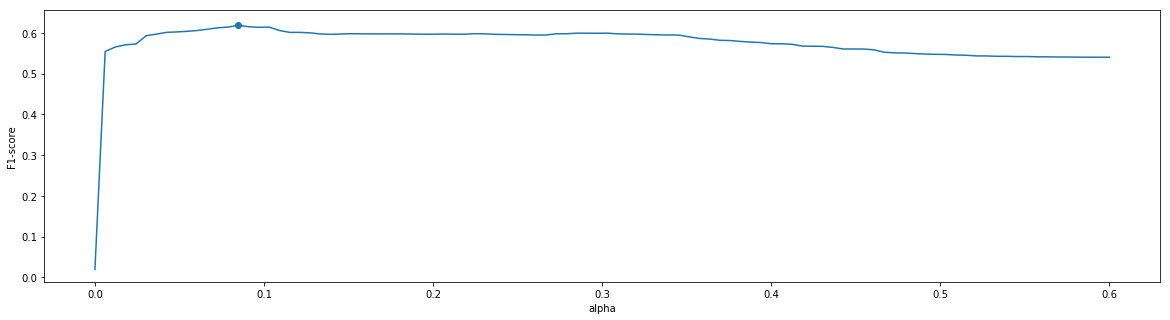

In [23]:
alphas = np.linspace(0.0, 0.6, 100)
scores = [get_score(alpha, y, y_hat_dummy) for alpha in alphas]

plot(alphas, scores);
scatter(alphas[np.argmax(scores)], np.max(scores));
ylabel('F1-score')
xlabel('alpha')


print(np.max(scores))
print(alphas[np.argmax(scores)])

alpha = alphas[np.argmax(scores)]

### Умный классификатор учитывающий пороги

In [24]:
%%time
smart_clf = OneVsRestClassifier(LogisticRegression(random_state=42, C=100))
smart_clf.fit(X_train, y_train)
answer = smart_clf.predict(X_test)
print(clf)

<function clf at 0x7f2cca55c730>
CPU times: user 4min, sys: 32 ms, total: 4min
Wall time: 4min


In [25]:
print("Accuracy score {0}".format(accuracy_score(y_true=y_test, y_pred=answer)))
print("F1 score {0}".format(f1_score(y_true=y_test, y_pred=answer, average='samples')))

Accuracy score 0.5640132642348903
F1 score 0.5644826226302955


In [26]:
def return_thresolded_prediction_ua(predictions, alpha):
    ua_list = []
    for i, proba in enumerate(predictions):
        if proba > alpha:
            ua_list.append(return_ua(i))
    return ua_list

### А теперь предсказания по настоящему

In [27]:
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', True)

def smart_prediction(clf, X_test, y_test, alpha):
    predictions_proba = clf.predict_proba(X_test)

    y_test_names = pd.DataFrame(y_test).apply(lambda l: return_prediction_ua(l), axis=1)
    y_predicted = pd.DataFrame(predictions_proba).apply(lambda l: return_thresolded_prediction_ua(l, alpha), axis=1)

    compare_answers = []
    for i, y_tst in enumerate(y_test_names):
        current_answer = True
        for j, tst_val in enumerate(y_tst):
            if tst_val not in y_predicted[i]:
                current_answer = False
        compare_answers.append(current_answer)
        
    return y_test_names, y_predicted, compare_answers


In [28]:
y_test_names, y_predicted, compare_answers = smart_prediction(smart_clf, X_test, y_test, alpha)

compare_frame = pd.concat(
    [
        y_test_names,
        y_predicted, 
        pd.DataFrame(compare_answers)
    ], keys=['test', 'predicted', 'correctness'], axis=1, join='inner')

compare_frame.predicted.iloc[3][1]

['Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http://mj12bot.com/)']

In [29]:
smart_accuracy = numpy.sum(compare_answers) / y_test.shape[0]
smart_accuracy

0.80610221459399112

### Неплохая «Глупая» классификация вышла (80% угаданных)

### Попробуем NaiveBayes

In [30]:
%%time
from sklearn.naive_bayes import MultinomialNB

nb_clf = OneVsRestClassifier(MultinomialNB(), n_jobs=-1)
nb_clf.fit(X_train, y_train)
nb_answer = nb_clf.predict(X_test)
print("Accuracy score {0}".format(accuracy_score(y_true=y_test, y_pred=nb_answer)))
print("F1 score {0}".format(f1_score(y_true=y_test, y_pred=nb_answer, average='samples')))

Accuracy score 0.26031894152738666
F1 score 0.4965621141397161
CPU times: user 3.11 s, sys: 120 ms, total: 3.23 s
Wall time: 3.93 s


**Результат не самый лучший, зато вычисления ну очень быстрые**

**Попробуем так же с порогами поизвращаться**

In [31]:
params = {'estimator__alpha': np.logspace(-5, 5, 11)}

clf = OneVsRestClassifier(MultinomialNB())
cv = GridSearchCV(clf, params, n_jobs=-1, scoring=make_scorer(f1_score, average='samples'), cv=5)
cv.fit(X_train, y_train);

In [32]:
pd.DataFrame(cv.cv_results_)[['mean_test_score', 'params']].sort_values('mean_test_score', ascending=False)

,mean_test_score,params
0,0.506275,{'estimator__alpha': 1e-05}
1,0.506166,{'estimator__alpha': 0.0001}
2,0.505763,{'estimator__alpha': 0.001}
3,0.505121,{'estimator__alpha': 0.01}
5,0.499057,{'estimator__alpha': 1.0}
...,...,...
6,0.477966,{'estimator__alpha': 10.0}
7,0.334823,{'estimator__alpha': 100.0}
8,0.188592,{'estimator__alpha': 1000.0}
9,0.000000,{'estimator__alpha': 10000.0}


In [33]:
clf = OneVsRestClassifier(MultinomialNB(alpha=0.0001))
%time y_hat_dummy = cross_val_predict(clf, sparse_dummy, y, method='predict_proba')

CPU times: user 12.5 s, sys: 332 ms, total: 12.8 s
Wall time: 12.9 s


0.498712433818
0.593939393939


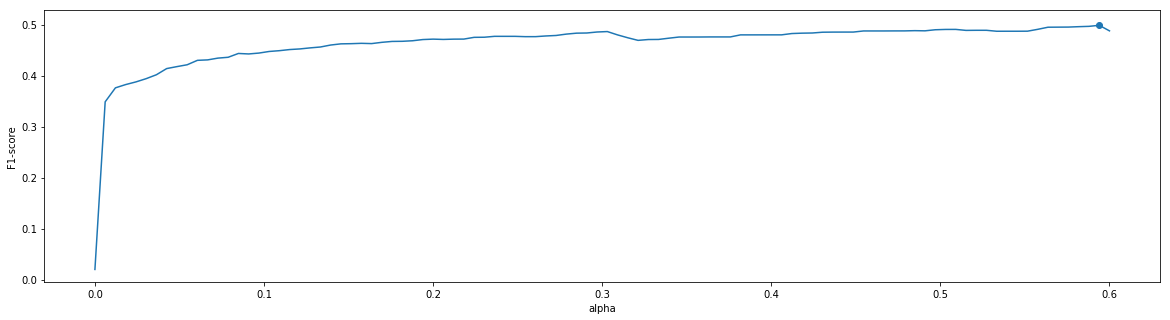

In [34]:
alphas = np.linspace(0.0, 0.6, 100)
scores = [get_score(alpha, y, y_hat_dummy) for alpha in alphas]

plot(alphas, scores);
scatter(alphas[np.argmax(scores)], np.max(scores));
ylabel('F1-score')
xlabel('alpha')


print(np.max(scores))
print(alphas[np.argmax(scores)])

mb_alpha = alphas[np.argmax(scores)]

In [35]:
%time 
mb_smart_clf = OneVsRestClassifier(MultinomialNB(alpha=0.0001))
mb_smart_clf.fit(X_train, y_train)
answer = smart_clf.predict(X_test)

y_test_names, y_predicted, mb_compare_answers = smart_prediction(mb_smart_clf, X_test, y_test, mb_alpha)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.53 µs


In [36]:
mb_compare_frame = pd.concat(
    [
        y_test_names,
        y_predicted, 
        pd.DataFrame(mb_compare_answers)
    ], keys=['test', 'predicted', 'correctness'], axis=1, join='inner')

first_answer = mb_compare_frame.predicted.iloc[1][1]
mb_compare_frame.predicted.iloc[2][1]

['Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:38.0) Gecko/20100101 Firefox/38.0',
 'Mozilla/5.0 (compatible; Yahoo! Slurp; http://help.yahoo.com/help/us/ysearch/slurp)',
 'Mediapartners-Google',
 'Mozilla/5.0 (iPhone; CPU iPhone OS 10_2_1 like Mac OS X) AppleWebKit/602.4.6 (KHTML, like Gecko) Version/10.0 Mobile/14D27 Safari/602.1',
 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/49.0.2623.112 Safari/537.36',
 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:51.0) Gecko/20100101 Firefox/51.0',
 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.95 YaBrowser/17.1.0.2034 Yowser/2.5 Safari/537.36',
 'Mozilla/5.0 (iPhone; CPU iPhone OS 10_2 like Mac OS X) AppleWebKit/602.3.12 (KHTML, like Gecko) Version/10.0 Mobile/14C92 Safari/602.1',
 'Mozilla/5.0 (Windows NT 6.1; rv:43.0) Gecko/20100101 Firefox/43.0',
 'Mozilla/5.0 (Windows N

In [37]:
mb_smart_accuracy = numpy.sum(mb_compare_answers) / y_test.shape[0]
mb_smart_accuracy

0.90603389378613919

### Неплохой «Глупый Байес» (90% угаданных)

Но получилось слишком много вероятных вариантов, потому точность будет низкой. Потому использовать Байеса в дальнейшем не очень хочется

## Tf-Idf

Значение Tf-Idf для каждого пары документ-слово состоит из двух компонент:
* Term frequency — логарифм встречаемости слова в документе
$$tf(t, d) = \log n_{t,d}$$

* Inverse Document frequency — логарифм обратной доли документов в которых встретилось данное слово
$$idf(t, D) = \log \frac{ \mid D \mid}{\mid \{ d_i \in D \mid t \in d_i \} \mid}$$

* Tf-Idf — кобминация tf и idf
$$ TfIdf(t, d, D) = tf(t, d) * idf(t, D)$$

In [38]:
tf_idf_vectorizer = sklearn.feature_extraction.text.TfidfTransformer()
tf_idf = tf_idf_vectorizer.fit_transform(sparse_dummy)
print(tf_idf.shape)
print(type(tf_idf))
print(sparse_dummy[:1])
print(tf_idf[:1])

(181851, 1042)
<class 'scipy.sparse.csr.csr_matrix'>
  (0, 1)	1
  (0, 2)	1
  (0, 23)	1
  (0, 71)	1
  (0, 535)	1
  (0, 536)	1
  (0, 645)	1
  (0, 646)	1
  (0, 647)	1
  (0, 660)	1
  (0, 663)	1
  (0, 684)	1
  (0, 686)	1
  (0, 687)	1
  (0, 706)	1
  (0, 706)	0.27615587655
  (0, 687)	0.243136142345
  (0, 686)	0.220008834592
  (0, 684)	0.264015084982
  (0, 663)	0.277554936539
  (0, 660)	0.286043115875
  (0, 647)	0.277650955254
  (0, 646)	0.281143440928
  (0, 645)	0.286671249375
  (0, 536)	0.277057295913
  (0, 535)	0.267453235376
  (0, 71)	0.218371154508
  (0, 23)	0.252327164808
  (0, 2)	0.228119132158
  (0, 1)	0.194062155613


** Логистическая регрессия по tf-idf**

In [39]:
%%time
X_train, X_test, y_train, y_test = train_test_split(tf_idf, y, test_size=0.33, random_state=42)

CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 99.5 ms


In [40]:
tf_clf = OneVsRestClassifier(LogisticRegression(random_state=42), n_jobs=-1)
tf_clf.fit(X_train, y_train)
tf_answer = tf_clf.predict(X_test)
print("Accuracy score {0}".format(accuracy_score(y_true=y_test, y_pred=tf_answer)))
print("F1 score {0}".format(f1_score(y_true=y_test, y_pred=tf_answer, average='samples')))

Accuracy score 0.5541983969605573
F1 score 0.5542095060350046


In [41]:
params = {'estimator__C': np.logspace(-5, 5, 11)}

clf = OneVsRestClassifier(LogisticRegression())
cv = GridSearchCV(clf, params, n_jobs=-1, scoring=make_scorer(f1_score, average='samples'), cv=5)
cv.fit(X_train, y_train);

In [42]:
pd.DataFrame(cv.cv_results_)[['mean_test_score', 'params']].sort_values('mean_test_score', ascending=False)

,mean_test_score,params
10,0.566710,{'estimator__C': 100000.0}
9,0.566684,{'estimator__C': 10000.0}
8,0.566622,{'estimator__C': 1000.0}
7,0.566140,{'estimator__C': 100.0}
6,0.563042,{'estimator__C': 10.0}
...,...,...
4,0.530827,{'estimator__C': 0.1}
3,0.413846,{'estimator__C': 0.01}
2,0.010292,{'estimator__C': 0.001}
0,0.000000,{'estimator__C': 1e-05}


## И снова выберем порог

In [43]:
tf_clf = OneVsRestClassifier(LogisticRegression(C=100000))
%time y_hat_tf_idf = cross_val_predict(tf_clf, tf_idf, y, method='predict_proba')

CPU times: user 17min 24s, sys: 1.03 s, total: 17min 25s
Wall time: 17min 28s


In [44]:
def get_score(alpha, y, y_hat):
    return f1_score(y, (y_hat > alpha).astype('int'), average='samples')

## Выбор порога для Dummy

* Качество с порогом по умолчанию — $F1=0.55$
* Качество с подобранным порогом — $F1=0.61$

0.619837595108
0.0848484848485


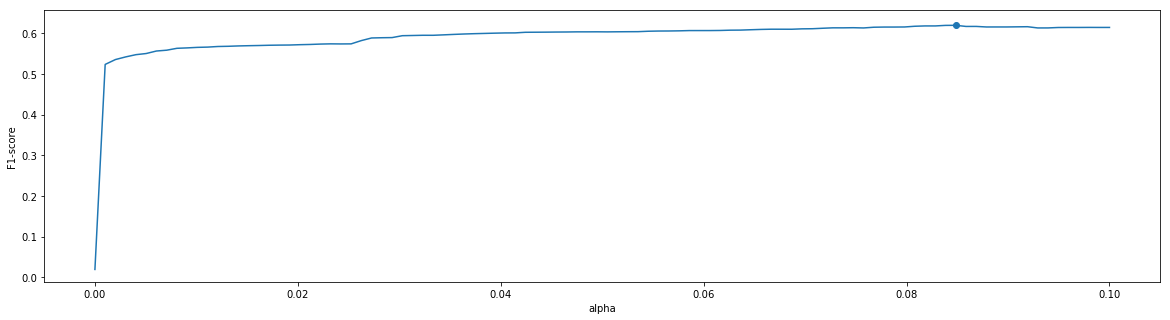

In [45]:
alphas = np.linspace(0.0, 0.1, 100)
scores = [get_score(alpha, y, y_hat_tf_idf) for alpha in alphas]

plot(alphas, scores);
scatter(alphas[np.argmax(scores)], np.max(scores));
ylabel('F1-score')
xlabel('alpha')


print(np.max(scores))
print(alphas[np.argmax(scores)])

tf_alpha = alphas[np.argmax(scores)]

In [46]:
%%time
smart_tf_clf = OneVsRestClassifier(LogisticRegression(random_state=42, C=100000))
smart_tf_clf.fit(X_train, y_train)
tf_answer = smart_tf_clf.predict(X_test)

CPU times: user 6min 8s, sys: 112 ms, total: 6min 8s
Wall time: 6min 9s


In [47]:
y_tf_test_names, y_tf_predicted, tf_compare_answers = smart_prediction(smart_clf, X_test, y_test, tf_alpha)

In [48]:
tf_compare_frame = pd.concat(
    [
        y_tf_test_names,
        y_tf_predicted, 
        pd.DataFrame(tf_compare_answers)
    ], keys=['test', 'predicted', 'correctness'], axis=1, join='inner')

tf_compare_frame.predicted.iloc[2][1]

[]

In [49]:
smart_tf_accuracy = numpy.sum(tf_compare_answers) / y_test.shape[0]
smart_tf_accuracy

0.30974321374414693